In [ ]:
# Install PyTorch and CLIP dependencies (skip if already installed)
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
import clip
from PIL import Image
import matplotlib.pyplot as plt

# Set up device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 110MiB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_size=128, channels=3):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Linear(latent_dim, 128 * self.init_size ** 2)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(),  # Changed from nn.ReLU(inplace=True)
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(),  # Changed from nn.ReLU(inplace=True)
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Instantiate the generator
latent_dim = 100
generator = Generator(latent_dim=latent_dim).to(device)


In [ ]:
# Define preprocessing for generated images to match CLIP's input format
clip_preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])


def clip_loss(image, text):
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text)

    # Use out-of-place normalization
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute similarity and return negative for loss
    similarity = (image_features @ text_features.T).mean()
    return -similarity  # Negative similarity for minimization



Epoch [0/1000], Loss: -0.296142578125


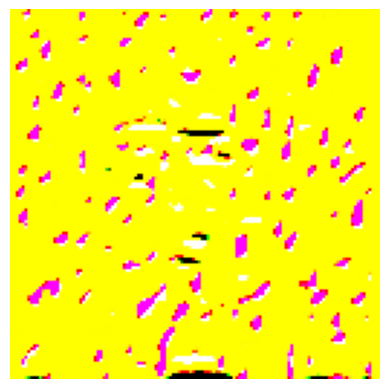

Epoch [100/1000], Loss: -0.30078125


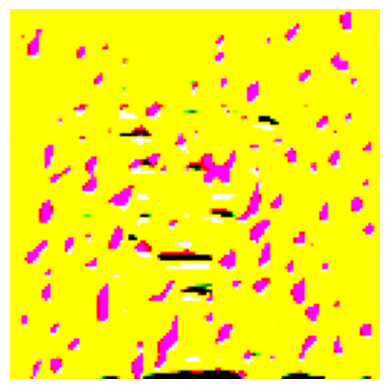

Epoch [200/1000], Loss: -0.294921875


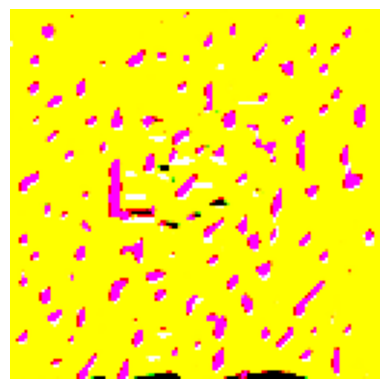

Epoch [300/1000], Loss: -0.29296875


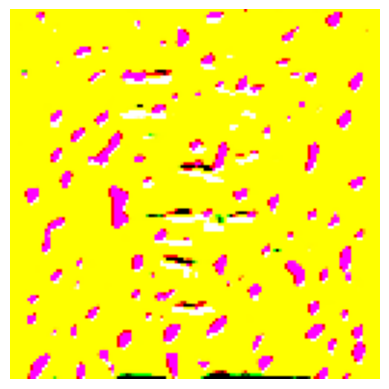

Epoch [400/1000], Loss: -0.29638671875


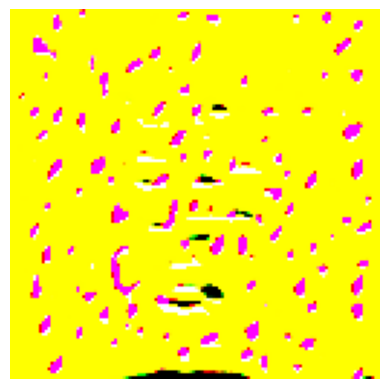

Epoch [500/1000], Loss: -0.29638671875


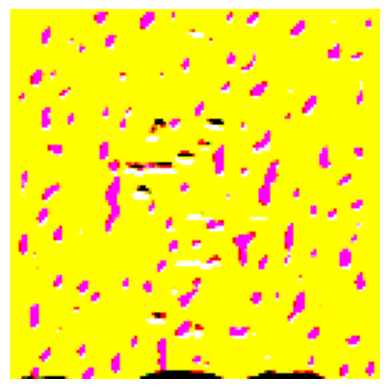

Epoch [600/1000], Loss: -0.291259765625


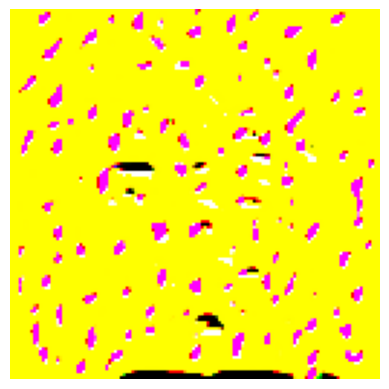

Epoch [700/1000], Loss: -0.286865234375


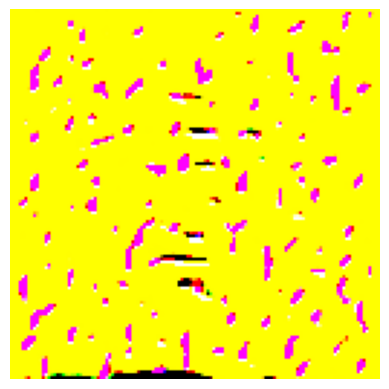

Epoch [800/1000], Loss: -0.303955078125


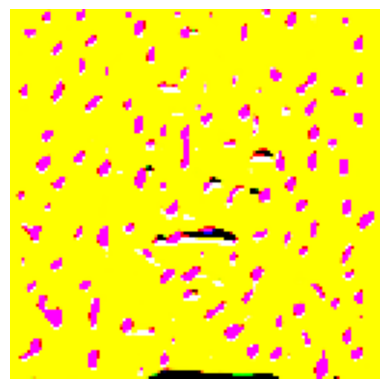

Epoch [900/1000], Loss: -0.29248046875


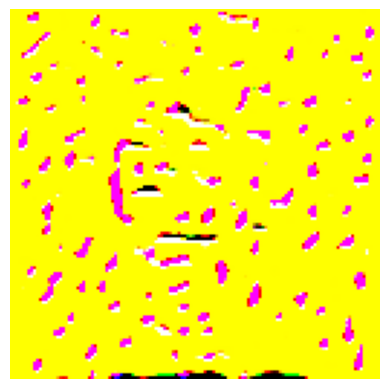

In [ ]:
# Training settings
num_epochs = 1000
batch_size = 1
learning_rate = 0.009
text_prompt = "a person with sunglasses"

# Encode text using CLIP
text_inputs = clip.tokenize([text_prompt]).to(device)

# Optimizer for the generator
optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    generator.train()
    optimizer.zero_grad()

    # Generate random noise and use it to generate an image
    z = torch.randn(batch_size, latent_dim).to(device)
    generated_images = generator(z)

    # Preprocess images for CLIP
    generated_images_clip = clip_preprocess(generated_images)
    generated_images_clip = generated_images_clip.to(device)

    # Compute CLIP loss
    loss = clip_loss(generated_images_clip, text_inputs)

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")

        # Display generated image
        generated_image = generated_images[0].cpu().detach()
        plt.imshow(generated_image.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.axis('off')
        plt.show()


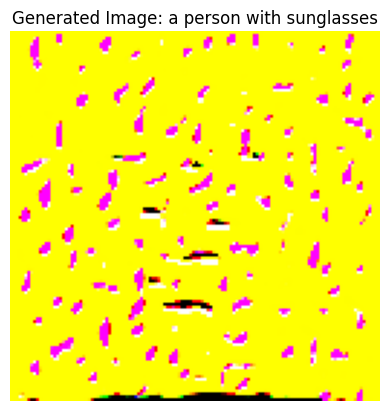

In [ ]:
# Generate an image after training
generator.eval()
z = torch.randn(1, latent_dim).to(device)
generated_image = generator(z)
generated_image = generated_image.cpu().detach().squeeze(0)

# Display the generated image
plt.imshow(generated_image.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.axis('off')
plt.title(f"Generated Image: {text_prompt}")
plt.show()
